In [26]:
import argparse
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)
import pickle

from datasets.dataset import _load_collection_real,_load_collection_syn,_load_collection_bbq_data
from models_utility.construct_models import _initialize_SMkernelhyp,_make_gpmodel
from utility.eval_metric import _evaluate_metric
import matplotlib.pyplot as plt

import random


#import matplotlib.pylab as pl
from matplotlib import rc
#rc('text', usetex=True)
rc('font', size=20)
rc('legend', fontsize=20)
#rc('text.latex', preamble=r'\usepackage{cmbright}')


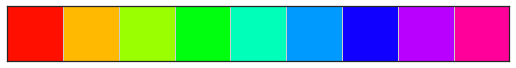

In [27]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(8+1, l=.5, s=1.0))

sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

# dataset

In [28]:
device = True

datafilename_list = ['CO2','airline','audio']

#filename = 'CO2'
filename = 'airline'
#filename = 'audio'



In [4]:
import os.path
from os import path
save_figure_path  = './jupyters/result_figure/exp1_varyingkernelerror_'+ filename + '_zeromean_v5'+'/'
os.makedirs(save_figure_path) if path.isdir(save_figure_path) is False else 1

1

In [50]:
#random_seed = 1000

x_train, x_test, y_train, y_test = _load_collection_real(filename,cuda_option=device)


x_full = torch.cat([x_train,x_test],dim = 0)
y_full = torch.cat([y_train,y_test],dim = 0)
y_mean = y_full.mean()
y_train -= y_mean
y_test -= y_mean
y_full -= y_full.mean()
y_full = torch.cat([y_train,y_test],dim = 0)







random_seed = 1000
setting_dict = {}
setting_dict['random_seed'] = random_seed
setting_dict['input_dim'] = x_train.shape[1]


if filename in [ 'CO2']:
    print('C02 setting') 
    setting_dict['init_sample_num'] = 500    
    #setting_dict['lr_hyp'] = 0.01
    setting_dict['lr_hyp'] = 0.005 
    #setting_dict['noise_err'] = .05*y_train.cpu().data.numpy().std()
    setting_dict['noise_err'] = .1*y_train.cpu().data.numpy().std()
    
    setting_dict['Num_Q'] = 8
    setting_dict['num_sample_pt'] = 5
    setting_dict['iter'] = 4000
    setting_dict['weight_rate'] = 0.1  #allocation rate
    
    
elif filename in ['airline']:
    print('airline setting') 
    setting_dict['init_sample_num'] = 500    
    setting_dict['lr_hyp'] = 0.005
    setting_dict['noise_err'] = .05*y_train.cpu().data.numpy().std()
    setting_dict['Num_Q'] = 6
    setting_dict['num_sample_pt'] = 5
    setting_dict['iter'] = 4000
    setting_dict['weight_rate'] = 0.1 #allocation rate
    #setting_dict['weight_rate'] = 0.1 #allocation rate

    
elif filename in ['audio']:
    print('audio setting') 
    setting_dict['init_sample_num'] = 500    
    setting_dict['lr_hyp'] = 0.005
    setting_dict['noise_err'] = 1.0
    setting_dict['Num_Q'] = 8
    setting_dict['num_sample_pt'] = 5
    setting_dict['iter'] = 4000
    setting_dict['weight_rate'] = 0.1
else:
    pass


setting_dict['kl_option'] = True    #['True','False']
setting_dict['num_batch'] = 1
#setting_dict['tau0'] = 100
setting_dict['num_rep'] = 1
setting_dict['optimizer'] = 'Adam'





#loaded collection#
airline setting


In [51]:
result_dict = {}
result_dict['Exp_setting'] = setting_dict
result_dict['Data_setting'] = {'x_train' : x_train.cpu().data.numpy(),
                               'y_train' : y_train.cpu().data.numpy(),
                               'x_test' : x_test.cpu().data.numpy(),
                               'y_test' : y_test.cpu().data.numpy()}

result_dict['loss'] = {}
result_dict['rmse'] = {}
result_dict['mnll'] = {}
result_dict['best_loss'] = {}
result_dict['best_rmse'] = {}
result_dict['best_mnll'] = {}

result_dict['pred_train_mu'] = {}
result_dict['pred_train_var'] = {}
result_dict['pred_test_mu'] = {}
result_dict['pred_test_var'] = {}
result_dict['param_history'] = {}
result_dict['error_history'] = {}




### modelsetup

In [52]:
ith_model_name = 'gpsm'

In [53]:
from models_utility.personalized_adam import Adam_variation


best_loss = np.inf
for ith in range(3):    
    setting_dict = _initialize_SMkernelhyp(x_train, y_train, setting_dict, random_seed + ith ,yesSM= True, filename = filename)        
    temp_model = _make_gpmodel(model_name=ith_model_name, setting_dict=setting_dict, device=device)
    if ith_model_name in ['gpvfe', 'gpvferbf']:
        temp_model._set_data(batch_x=x_train, batch_y=y_train)        
        temp_model._set_inducing_pt(2 * setting_dict['Num_Q'] * setting_dict['num_sample_pt'])
        optimizable_param =  [*temp_model.parameters(),temp_model.likelihood.variance]
    elif ith_model_name in ['vssgp']:
        temp_model._set_data(batch_x=x_train, batch_y=y_train)                
        temp_model._set_inducing_pt( setting_dict['Num_Q'] * setting_dict['num_sample_pt'])
        optimizable_param =  [*temp_model.parameters()]
    else:
        temp_model._set_data(batch_x=x_train, batch_y=y_train)                
        optimizable_param =  [*temp_model.parameters(),temp_model.likelihood.variance]


    
    temp_optimizer = torch.optim.Adam(optimizable_param ,
                                      lr=setting_dict['lr_hyp'],
                                      betas=(0.9, 0.99),
                                      eps=1e-08,
                                      weight_decay=0.0)    

    for i in range(100 + 1):    
        temp_optimizer.zero_grad()    
        #losstotal = temp_model.compute_loss(batch_x=x_train[::2], batch_y=y_train[::2], kl_option=setting_dict['kl_option'])
        losstotal = temp_model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])
        losstotal.backward()
        temp_optimizer.step()
        
    # best model chosen
    if best_loss >= losstotal.cpu().data.numpy():
        best_loss = losstotal.cpu().data.numpy()        
        ith_model = temp_model
        optimizer = temp_optimizer
        print('%d init loss: %.4f '%(ith,losstotal.cpu().data.numpy()))
        print('%d model chosen '%(ith))
    else:
        pass
    

0 init loss: 7025.6117 
0 model chosen 
1 init loss: 6987.4582 
1 model chosen 
2 init loss: 6288.0836 
2 model chosen 


In [54]:
def _clone_parms(ith_model):
    if hasattr(ith_model,'kernel'):
        weight_ = ith_model.kernel.weight.data.clone()
        mu_ = ith_model.kernel.mu.data.clone()
        std_ = ith_model.kernel.std.data.clone()
        var_ = ith_model.likelihood.variance.data.clone()
    return weight_,mu_,std_,var_

def _transfer_params(model_reg,weight_,mu_,std_,var_):
    model_reg.weight.data = weight_
    model_reg.mu.data = mu_
    model_reg.std.data = std_
    model_reg.likelihood.variance.data = var_
    return model_reg

### proposed 

In [55]:
weight_reg = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict, device=device)
weight_reg._set_data(x_train,y_train)
equal_reg = _make_gpmodel(model_name='equal_reg', setting_dict=setting_dict, device=device)
equal_reg._set_data(x_train,y_train)


In [56]:
def _compute_kernelGramerror(x_train,y_train,x_test,y_test,
                             exact_sm,sm_norm,weight_reg,equal_reg, num_spt = 1,observed_period=100):
    
    weight_reg._set_num_spectralpt(num_spt )
    equal_reg._set_num_spectralpt(num_spt)

    temp_w_error_list,temp_e_error_list = [],[]
    temp_w_loss_list,temp_e_loss_list = [],[]
    temp_w_rmse_list,temp_e_rmse_list = [],[]
    
    for ijk in range(100):        
        with torch.no_grad():
            w_loss = weight_reg._compute_nlml(x_train,y_train)
            e_loss = equal_reg._compute_nlml(x_train,y_train)                            
            w_appkernel = weight_reg._compute_kernel_sm_approximate(x_train)
            e_appkernel = equal_reg._compute_kernel_sm_approximate(x_train)                            
            w_pred_mu,w_pred_var = weight_reg._predict(x_test)
            e_pred_mu,e_pred_var = equal_reg._predict(x_test)                            

        w_error = exact_sm - w_appkernel.cpu().data.numpy()
        e_error = exact_sm - e_appkernel.cpu().data.numpy()

        w_rmse,w_mnll = _evaluate_metric(w_pred_mu,w_pred_var, y_test)
        e_rmse,e_mnll = _evaluate_metric(e_pred_mu,e_pred_var, y_test)
        
        

        w_error_fnorm = fnorm(w_error,'fro') 
        e_error_fnorm = fnorm(e_error,'fro')

        temp_w_error_list.append(w_error_fnorm)
        temp_e_error_list.append(e_error_fnorm)
        
        temp_w_loss_list.append(w_loss.cpu().data.numpy())
        temp_e_loss_list.append(e_loss.cpu().data.numpy())
        
        temp_w_rmse_list.append(w_rmse)
        temp_e_rmse_list.append(e_rmse)
        

        

    w_mean,w_std = np.array(temp_w_error_list).mean().round(3),np.array(temp_w_error_list).std().round(3)
    e_mean,e_std = np.array(temp_e_error_list).mean().round(3),np.array(temp_e_error_list).std().round(3)
   
    wl_mean,wl_std = np.array(temp_w_loss_list).mean().round(3),np.array(temp_w_loss_list).std().round(3)
    el_mean,el_std = np.array(temp_e_loss_list).mean().round(3),np.array(temp_e_loss_list).std().round(3)

    wr_mean,wr_std = np.array(temp_w_rmse_list).mean().round(3),np.array(temp_w_rmse_list).std().round(3)
    er_mean,er_std = np.array(temp_e_rmse_list).mean().round(3),np.array(temp_e_rmse_list).std().round(3)
    
    #return w_mean,w_std,e_mean,e_std
    return w_mean,w_std,e_mean,e_std,\
           wl_mean,wl_std,el_mean,el_std,\
           wr_mean,wr_std,er_mean,er_std

In [57]:
observed_period = 200
num_spt1 = 4

In [58]:
import torch.nn.utils as torch_utils
from scipy.linalg import norm as fnorm


param_history_list = []
error_history_list1,error_history_list2 = [],[]
loss_history_list,loss_history_list1,loss_history_list2 = [],[],[]
rmse_history_list,rmse_history_list1,rmse_history_list2 = [],[],[]


#rmse_history_list = []
print('#'*100)
print(ith_model_name)
ith_model.train()
for i in range(setting_dict['iter'] + 1):
    optimizer.zero_grad()
    
    ith_tic = time.time()
    losstotal = ith_model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])
    losstotal.backward()
    optimizer.step()
    ith_toc = time.time()

    with torch.no_grad():
        pred_train_mu, pred_train_var = ith_model._predict(inputs_new=x_train)
        pred_test_mu, pred_test_var = ith_model._predict(inputs_new=x_test)        
        ith_rmse,ith_mnll = _evaluate_metric(pred_test_mu, pred_test_var, y_test)


    
    if i % observed_period == 0 :
        print('%d th loss0 : %.4f, test rmse : %.4f, test mnll: : %.4f' % (i,losstotal.cpu().data.numpy(),ith_rmse,ith_mnll))        
        #print('%d th loss0 : %.4f, reg0 : %.4f, test rmse : %.4f, test mnll: : %.4f' % (i,ith_loss.cpu().data.numpy(),ith_reg.cpu().data.numpy(),ith_rmse,ith_mnll))
        try:
            print('self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance')            
            print(ith_model.weight.exp().squeeze(),ith_model.mu.exp().squeeze(),ith_model.std.exp().squeeze(),ith_model.likelihood.variance.transform()**2)
            print('\n')
            print('self.num_samplept_list_at')
            print(ith_model.num_samplept_list_at)
            
        except:
            print('self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance')            
            print(ith_model.kernel.weight.exp().squeeze(),ith_model.kernel.mu.exp().squeeze(),ith_model.kernel.std.exp().squeeze(),ith_model.likelihood.variance.transform()**2)
            print('\n')
            pass
                
           #############################################################################
        
        if ith_model_name in ['gpsm','gpvfe']:
        ##ith_model_name = 'gpsm'
        #ith_model_name = 'gpvfe'
            # trace the kernel approximation error
            weight_,mu_,std_,var_ = _clone_parms(ith_model)
            weight_reg = _transfer_params(weight_reg,weight_,mu_,std_,var_)
            equal_reg = _transfer_params(equal_reg,weight_,mu_,std_,var_)

            exact_sm =ith_model.kernel.K(x_train).cpu().data.numpy() + ((ith_model.likelihood.variance.transform()**2)*torch.eye(x_train.shape[0]).cuda()).cpu().data.numpy() 
            sm_norm = fnorm(exact_sm,'fro')


            w_mean_2,w_std_2,e_mean_2,e_std_2,\
            wl_mean_2,wl_std_2,el_mean_2,el_std_2,\
            wr_mean_2,wr_std_2,er_mean_2,er_std_2 = _compute_kernelGramerror(x_train,y_train,x_test,y_test,
                                                                             exact_sm,sm_norm,weight_reg,equal_reg,num_spt = num_spt1,observed_period=observed_period) 
            
    

    
    
    
    
            print( (w_mean_2,w_std_2),( e_mean_2,e_std_2 ) ) 
            print( (losstotal.cpu().data.numpy()),(wl_mean_2,wl_std_2),( el_mean_2,el_std_2 ) ) 

            #############################################################################     
            param_history_list.append((weight_.exp().cpu().data.numpy(),
                                       mu_.exp().cpu().data.numpy(),
                                       std_.exp().cpu().data.numpy(),
                                       var_.exp().cpu().data.numpy()))
            #param_history_list.append((weight_,mu_,std_,var_))


            error_history_list1.append( (w_mean_2,w_std_2,     e_mean_2,e_std_2 )  )
            loss_history_list1.append( (wl_mean_2,wl_std_2,    el_mean_2,el_std_2 )  )
            rmse_history_list1.append( (wr_mean_2,wr_std_2,    er_mean_2,er_std_2 )  )

            
            
        loss_history_list.append( losstotal.cpu().data.numpy())
        rmse_history_list.append(ith_rmse)
        
        
        
        

        print('')



####################################################################################################
gpsm
0 th loss0 : 6239.7661, test rmse : 124.1782, test mnll: : 219.3366
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.6668, 1.5812, 1.4539, 1.6201, 1.4864, 1.5556], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0068, 0.1677, 0.0451, 0.3206, 0.2463, 0.0838], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([0.0015, 0.0031, 0.0488, 0.0387, 0.0171, 0.0041], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([27.3583], device='cuda:0', grad_fn=<PowBackward0>)


(286.262, 5.718) (285.866, 3.988)
6239.7661444235455 (6707.08, 1063.691) (6683.505, 1011.762)

200 th loss0 : 2479.6446, test rmse : 108.0795, test mnll: : 83.9164
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor

(9587.536, 3693.331) (12561.153, 5996.303)
366.0256996963864 (380.109, 9.322) (385.64, 14.101)

2400 th loss0 : 364.7833, test rmse : 35.9178, test mnll: : 5.8982
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([5249.8228,  310.6063,   79.2562,   31.4959,   25.4998,  936.7433],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0029, 0.1683, 0.0063, 0.3321, 0.2497, 0.0831], device='cuda:0',
       grad_fn=<SqueezeBackward0>) tensor([5.3195e-05, 1.2372e-03, 1.8821e-02, 1.3612e-03, 1.3477e-03, 1.9338e-03],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([39.3660], device='cuda:0', grad_fn=<PowBackward0>)


(9633.324, 3380.358) (12698.612, 5797.35)
364.7833414809397 (379.723, 9.864) (383.807, 11.477)

2600 th loss0 : 364.3286, test rmse : 35.5796, test mnll: : 5.8929
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
self.weight.exp(),self.mu.exp(),self.std.ex

### summary

In [59]:
rmse = np.asarray(rmse_history_list)
##########################################################################################
w_mean1,w_std1 = np.asarray(error_history_list1)[:,0],np.asarray(error_history_list1)[:,1]
e_mean1,e_std1 = np.asarray(error_history_list1)[:,2],np.asarray(error_history_list1)[:,3]


##########################################################################################
wl_mean1,wl_std1 = np.asarray(loss_history_list1)[:,0],np.asarray(loss_history_list1)[:,1]
el_mean1,el_std1 = np.asarray(loss_history_list1)[:,2],np.asarray(loss_history_list1)[:,3]


##########################################################################################

wr_mean1,wr_std1 = np.asarray(rmse_history_list1)[:,0],np.asarray(rmse_history_list1)[:,1]
er_mean1,er_std1 = np.asarray(rmse_history_list1)[:,2],np.asarray(rmse_history_list1)[:,3]



In [60]:
weights_history_list = []
mus_history_list = []
stds_history_list = []
vars_history_list = []
for ith_param in param_history_list:
    weights_history_list.append(ith_param[0].squeeze())
    mus_history_list.append(ith_param[1].squeeze())
    stds_history_list.append(ith_param[2].squeeze())
    vars_history_list.append(ith_param[3].squeeze())
weights_history_list = np.asarray(weights_history_list)
mus_history_list = np.asarray(mus_history_list)
stds_history_list = np.asarray(stds_history_list)
vars_history_list = np.asarray(vars_history_list)

In [61]:
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "'custom"
# plt.rcParams["mathtext.fontset"] = "dejavuserif"


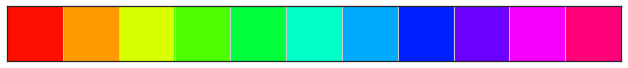

In [62]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'stix:italic'
#plt.rc('font', weight='bold')

#current_palette = sns.color_palette(sns.hls_palette(6+1, l=.5, s=1.0))
current_palette = sns.color_palette(sns.hls_palette(10+1, l=.5, s=1.0))

sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [63]:
figsiz = (7,5)
markersiz = 8
#figsiz = (5,3.5)

### ratio

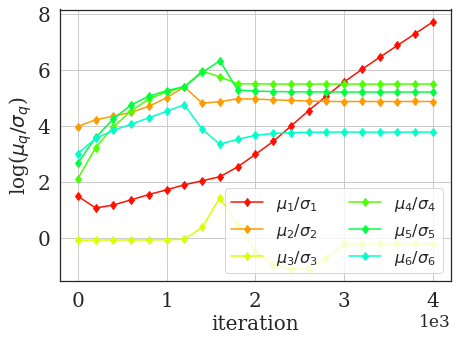

In [64]:
idx = observed_period*np.arange(len(w_mean1))
plt.figure(figsize = figsiz)    
for i in range(setting_dict['Num_Q'] ):
    #plt.plot(idx,mus_history_list[:,i],color =  current_palette[i],marker = 'd')    
    #plt.plot(idx,np.log(mus_history_list[:,i]/stds_history_list[:,i]),color =  current_palette[i],marker = 'd')    
    
    plt.plot(idx,np.log(mus_history_list[:,i]/stds_history_list[:,i] + 1e-12),color =  current_palette[i],marker = 'd',label = '$\mu_{0}/\sigma_{0}$'.format(i+1))        
    #plt.plot(idx,np.log(stds_history_list[:,i]/mus_history_list[:,i]),color =  current_palette[i],marker = 'd',label = '$\sigma_{0}$/$\mu_{0}$'.format(i))    
    #plt.plot(idx,stds_history_list[:,i]/mus_history_list[:,i],color =  current_palette[i],marker = 'd')    
    

        
plt.xlabel('iteration',fontsize = 20)
#plt.ylabel('r$\log \mathrm{std}_q/\mathrm{std}_q$',fontsize = 20)
#plt.ylabel(r'log $\sigma_{q}$ / $\mu_{q}$',fontsize = 20)
plt.ylabel(r'log($\mu_{q}/\sigma_{q}$)',fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)

#plt.legend(bbox_to_anchor=(1.025,1.1), fontsize = 14,ncol=1)
#plt.legend(bbox_to_anchor=(1.0,1.35), fontsize = 14,ncol=4)
plt.legend(loc = 'best',ncol = 2, fontsize = 16)
plt.gca().yaxis.get_offset_text().set_size(17)
plt.gca().xaxis.get_offset_text().set_size(17)

plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))


plt.show()




### weights

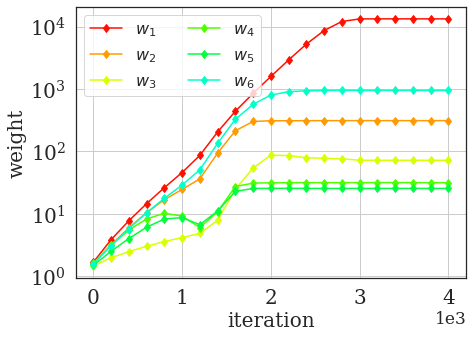

In [65]:
idx = observed_period*np.arange(len(w_mean1))
plt.figure(figsize = figsiz)    
for i in range(setting_dict['Num_Q'] ):
    plt.plot(idx,weights_history_list[:,i],color =  current_palette[i],marker = 'd',label = '$w_{0}$'.format(i+1))
   
        
plt.xlabel('iteration',fontsize = 20)
#plt.ylabel('$\mathit{w_{q}}$',fontsize = 20)
plt.ylabel('weight',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
#plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.yscale('log',basey=10)


#plt.legend(bbox_to_anchor=(1.03,1.4), fontsize = 15.2,ncol=4)
plt.legend(loc = 'best',ncol = 2, fontsize = 16)
plt.gca().yaxis.get_offset_text().set_size(17)
plt.gca().xaxis.get_offset_text().set_size(17)


plt.show()




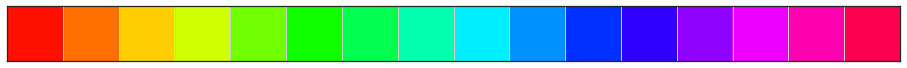

In [66]:
current_palette = sns.color_palette(sns.hls_palette(15+1, l=.5, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

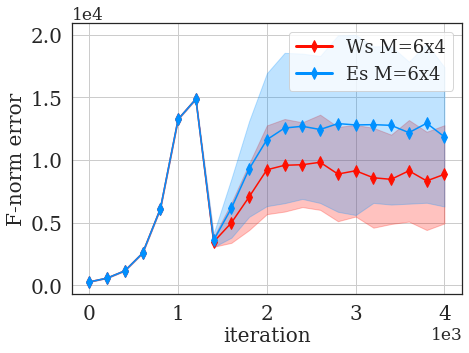

In [67]:
idx = observed_period*np.arange(len(w_mean1))

markersiz = 8

plt.figure(figsize = figsiz)

idxh = 0
#plt.plot(idx,w_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz, label='weight M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1)) # label = 'weight'
plt.plot(idx,w_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz, label='Ws M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1)) # label = 'weight'
#plt.plot(idx,w_mean1,color =  current_palette[0],marker = 'd',markersize = markersiz)
plt.fill_between( idx,
                  w_mean1 - w_std1,
                  w_mean1 + w_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])


#plt.plot(idx,w_mean2,color =  current_palette[0],marker = '*',label = 'weight')
# plt.plot(idx,w_mean2,color =  current_palette[idxh+1],marker = 's',markersize = markersiz, label= 'weight M={0}x{1}'.format(setting_dict['Num_Q'],num_spt2)) #label = 'weight M=Qx20'
# plt.fill_between( idx,
#                   w_mean2 - w_std2,
#                   w_mean2 + w_std2,
#                   alpha = 0.25, edgecolor = current_palette[idxh+1], facecolor =  current_palette[idxh+1])



idxh = 9
#plt.plot(idx,e_mean1,color =  current_palette[idxh],label = 'equal') #label = 'equal M=Qx2'
#plt.plot(idx,e_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz, label= 'equal M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1) ) #label = 'equal M=Qx2'
plt.plot(idx,e_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz, label= 'Es M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1) ) #label = 'equal M=Qx2'

plt.fill_between( idx,
                  e_mean1 - e_std1,
                  e_mean1 + e_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])

# plt.plot(idx,e_mean2,color =  current_palette[idxh+1],marker = 's',markersize = markersiz, label= 'equal M={0}x{1}'.format(setting_dict['Num_Q'],num_spt2)) #'equal M=Qx20'
# plt.fill_between( idx,
#                   e_mean2 - e_std2,
#                   e_mean2 + e_std2,
#                   alpha = 0.25, edgecolor = current_palette[idxh+1], facecolor =  current_palette[idxh+1])



plt.xlabel('iteration',fontsize = 20)
plt.ylabel('F-norm error',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))



plt.gca().yaxis.get_offset_text().set_size(17)
plt.gca().xaxis.get_offset_text().set_size(17)

################################################################################################################################
## rmse
# plt.twinx()            
# plt.plot(idx,rmse,linewidth = 2,marker = 'd',markersize=markersiz,color = 'black',label='rmse')
# plt.yticks(fontsize = 15)
# plt.locator_params(axis='y', nbins=6)
# plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.legend(loc = 'center right', fontsize = 18.)
################################################################################################################################

leg = plt.legend(loc='best',ncol = 1, fontsize = 18 , columnspacing = 0.65)
#leg = plt.legend(loc='lower left', fontsize = 14)
for line in leg.get_lines():
    line.set_linewidth(3) 
plt.gca().yaxis.get_offset_text().set_size(17)


plt.show()




### loss

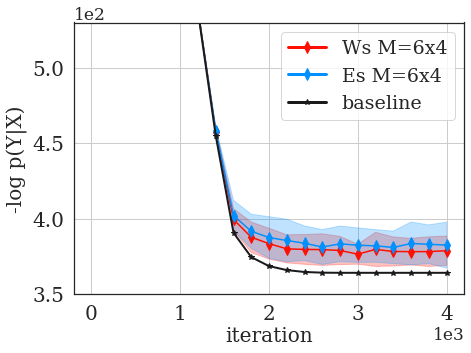

In [68]:
idx = observed_period*np.arange(len(w_mean1))

plt.figure(figsize = figsiz)

idxh = 0
plt.plot(idx,wl_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'Ws M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  wl_mean1 - wl_std1,
                  wl_mean1 + wl_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])





idxh = 9
plt.plot(idx,el_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'Es M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  el_mean1 - el_std1,
                  el_mean1 + el_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])




plt.plot(idx,loss_history_list,color =  'k',marker = '*',linewidth =2,label = 'baseline')


plt.xlabel('iteration',fontsize = 20)
plt.ylabel('-log p(Y|X)',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_size(17)
plt.gca().xaxis.get_offset_text().set_size(17)


plt.ylim([350,530]) #airline new




leg = plt.legend(loc='best', fontsize = 19)
#leg = plt.legend(loc='lower left', fontsize = 14)
for line in leg.get_lines():
    line.set_linewidth(3) 
plt.gca().yaxis.get_offset_text().set_size(17)


plt.show()




### rmse

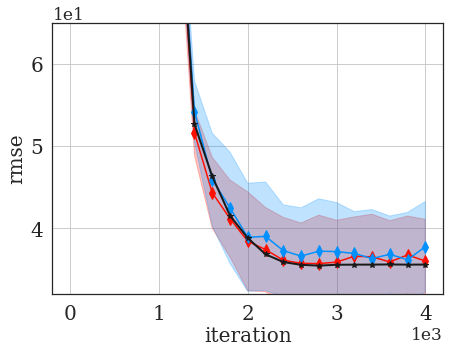

In [69]:
idx = observed_period*np.arange(len(w_mean1))

plt.figure(figsize = figsiz)
#####################################################################################################
idxh = 0

plt.plot(idx,wr_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'Ws M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  wr_mean1 - wr_std1,
                  wr_mean1 + wr_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])


idxh = 9
plt.plot(idx,er_mean1,color =  current_palette[idxh],marker = 'd',markersize = markersiz,label = 'Es M={0}x{1}'.format(setting_dict['Num_Q'],num_spt1))
plt.fill_between( idx,
                  er_mean1 - er_std1,
                  er_mean1 + er_std1,
                  alpha = 0.25, edgecolor = current_palette[idxh], facecolor =  current_palette[idxh])



plt.plot(idx,rmse_history_list,color =  'k',marker = '*',linewidth = 2 ,label = 'base')



plt.xlabel('iteration',fontsize = 20)
plt.ylabel('rmse',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_size(17)
plt.gca().xaxis.get_offset_text().set_size(17)


plt.ylim([32,65]) #airline





plt.show()




### test rmse

In [70]:
with torch.no_grad():
    pred_train_mu, pred_train_var = ith_model._predict(inputs_new=x_train)
    pred_test_mu, pred_test_var = ith_model._predict(inputs_new=x_test)


### prediction

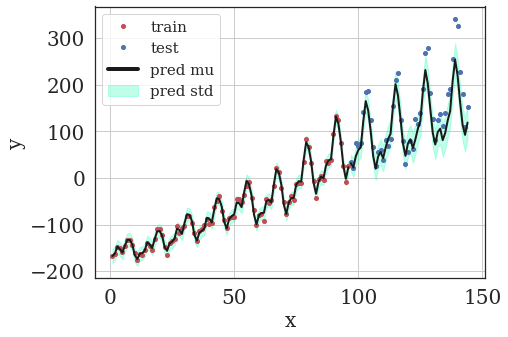

In [71]:
figsiz = (7,5)

ith = 7
plt.figure(figsize = figsiz)


plt.plot(x_train.cpu().data.numpy().squeeze(),y_train.cpu().data.numpy().squeeze(),'r.',markersize = 8, label='train')
plt.plot(x_test.cpu().data.numpy().squeeze(),y_test.cpu().data.numpy().squeeze(),'b.',markersize = 8, label='test')

plt.plot(x_train.cpu().data.numpy().squeeze(),pred_train_mu.cpu().data.numpy().squeeze(),'k',linewidth = 2, label='pred mu')

plt.fill_between( x_train.cpu().data.numpy().squeeze(),
                  pred_train_mu.cpu().data.numpy().squeeze() + 2*pred_train_var.sqrt().cpu().data.numpy().squeeze(),
                  pred_train_mu.cpu().data.numpy().squeeze() - 2*pred_train_var.sqrt().cpu().data.numpy().squeeze(),
                  alpha = 0.25, edgecolor = current_palette[ith], facecolor =  current_palette[ith], label='pred std')

plt.plot(x_test.cpu().data.numpy().squeeze(),pred_test_mu.cpu().data.numpy().squeeze() ,'k',linewidth = 2)
plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() + 2*pred_test_var.sqrt().cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() - 2*pred_test_var.sqrt().cpu().data.numpy().squeeze(),
                  alpha = 0.25, edgecolor = current_palette[ith], facecolor =  current_palette[ith])



plt.xlabel('x',fontsize = 20)
plt.ylabel('y',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)



leg = plt.legend(loc='best', fontsize = 15)
for line in leg.get_lines():
    line.set_linewidth(4) 
    line.set_markersize(4) 

plt.show()
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze() + 2*prede_test_var.sqrt().cpu().data.numpy().squeeze() ,'g')
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze(),'g')
# plt.plot(x_full.cpu().data.numpy().squeeze(),prede_test_mu.cpu().data.numpy().squeeze() - 2*prede_test_var.sqrt().cpu().data.numpy().squeeze() ,'g')
